In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
logging.getLogger("qick_processor").setLevel(logging.WARNING)

In [47]:
from qick.drivers.peripherals import QICK_Time_Tagger
import time

class QickTTSoc(QickSoc):

    # Constructor.
    def __init__(self, bitfile, **kwargs):
        super().__init__(bitfile=bitfile, **kwargs)
        self.qtt = self.qick_time_tagger_0
        
        # add the time-tagger channels to the firmware description
        self['extra_description'].append("\n\tTime tagger channels:")
        for i, (_, adcdesc) in enumerate(self.qtt.adcs):
            self['extra_description'].append("\t%d:\t%s" % (i, adcdesc) )
            
        # add the arm pin to the tproc pins list
        tproccfg = self['tprocs'][0]
        ((block, port),) = self.metadata.trace_sig('qick_time_tagger_0','arm_i')
        portnum, porttype = self.tproc.port2ch(port)
        tproccfg['output_pins'].append((porttype, portnum, 0, 'arm time tagger'))
            
    def tt_calibrate_adc(self, tt_ch):
        """Calibrate the selected time-tagger channel's ADC.
        Before calling this, you need to start playing a continuous low-frequency signal into that ADC.
        """
        tile, block = [int(x) for x in self.qtt.adcs[tt_ch][0]]
        self.rf.adc_tiles[tile].blocks[block].CalibrationMode=2 # optimized for [DC, 0.4*fs]
        self.rf.adc_tiles[tile].blocks[block].CalFreeze['FreezeCalibration']=0
        time.sleep(1)
        self.rf.adc_tiles[tile].blocks[block].CalFreeze['FreezeCalibration']=1

In [48]:
soc = QickTTSoc('/data/fw/2025-02-12_216_tprocv2r21_qtt/qick_216.bit')
soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.314

Firmware configuration (built Wed Feb 12 18:40:41 2025):

	Global clocks (MHz): tProcessor 614.400, RF reference 245.760

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3

	1 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 2
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		axis_avg_buffer v1.1 (has edge counter)
		maxlen 8192 accumulated, 4096 decimated (13.333 us)
		triggered by tport 10, pin 0, feedback to tProc input 0
		ADC tile 2, blk 0 is 0_226, on JHC7

	9 digital output pins:
	0:	PMOD0_0_LS
	1:	PMOD0_1_LS
	2:	PMOD0_2_LS
	3:	PMOD0_3_LS
	4:	PMOD0_4_LS
	5:	PMOD

In [5]:
# ID of the generator that's connected to the time tagger
GEN_CH_TT = 1
# ID of the generator that's connected to regular readout
GEN_CH_REG = 0
# ID of the regular readout that's connected to a generator
RO_CH = 0
# ID of the time-tagger channel that's connected to a generator
TT_CH = 0

In [36]:
soc.qtt.info()
soc.qtt.get_config(print_cfg = True)
soc.qtt.print_axi_regs()
soc.qtt.print_debug()

---------------------------------------------
 QICK Time Tagger INFO 
---------------------------------------------
Connections:
 ADC0 : ADC tile 2, blk 2 is 2_226, on JHC7
 ADC1 : ADC tile 2, blk 3 is 3_226, on JHC8
 ADC2 : not connected
 ADC3 : not connected
Configuration:
 adc_qty       : 2
 tag_mem_size  : 65536
 cmp_slope     : 0
 cmp_inter     : 4
 arm_store     : 1
 arm_mem_size  : 1024
 smp_store     : 1
 smp_mem_size  : 262144
----------

--- AXI Time Tagger CONFIG
--- AXI Time Tagger CONFIG
 FILTER           : 0
 SLOPE            : 0
 INTERPOLATION    : 0
 WRITE SAMPLE QTY : 0
 INVERT INPUT     : 0
---------------------------------------------
--- AXI Registers
  qtt_ctrl           0 - 0000_0000_0000_0000_0000_0000_0000_0000
   qtt_cfg           0 - 0000_0000_0000_0000_0000_0000_0000_0000
   dma_cfg        4101 - 0000_0000_0000_0000_0001_0000_0000_0101
   axi_dt1        1000 - 0000_0000_0000_0000_0000_0011_1110_1000
   proc_dt           0 - 0000_0000_0000_0000_0000_0000_0000_

In [7]:
soc.qtt.clear_mems(verbose=True)

TAG0 0
TAG1 0
TAG2 0
TAG3 0
ARM 0
SMP 0


In [134]:
class CalProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=1)
        self.add_pulse(ch=gen_ch, name="myconst",
                       style="const", 
                       length=1.0, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                       mode='periodic'
                      )

    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        
config = {'gen_ch': GEN_CH_TT,
          'freq': 100,
         }

calprog = CalProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
calprog.run(soc)
soc.tt_calibrate_adc(TT_CH)
soc.reset_gens()

In [58]:
class PeripheralArmingProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus",
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst",
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )
        self.asm_inst({'CMD': 'PA', 'C_OP': '1', 'R1': 'r1'}) # arm

    def _body(self, cfg):
#         self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0)
#         self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)

    def _cleanup(self, cfg):
        self.wait(10)
        self.asm_inst({'CMD': 'PA', 'C_OP': '0', 'R1': 'r1'}) # disarm
        
config = {'gen_ch': GEN_CH_TT,
          'freq': 0,
         }

prog = PeripheralArmingProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

In [151]:
class TriggerArmingProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)

        ramp_len = 0.1
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.02,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus",
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst",
                       style="const", 
                       length=0.05,
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )
        self.trigger(pins=[8], t=0, width=10)

    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.5)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=1.0)

config = {'gen_ch': GEN_CH_TT,
          'freq': 0,
         }

prog = TriggerArmingProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

In [152]:
soc.qtt.set_config(cfg_filter=0, cfg_slope=0, cfg_inter=0, smp_wr_qty=32, cfg_invert=0)
soc.qtt.set_dead_time(100)
soc.qtt.set_threshold(500)

soc.qtt.clear_mems()

# soc.qtt.arm()
prog.run_rounds(soc, rounds=1)
# soc.qtt.disarm()
print(soc.qtt.tag0_qty)
print(soc.qtt.read_mem('TAG0'))

  0%|          | 0/1 [00:00<?, ?it/s]

3
[2627 3860 5016]


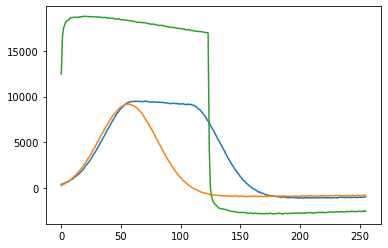

In [153]:
if soc.qtt.smp_qty>0:
    allsamps = soc.qtt.read_mem('SMP')
    for i, samps in enumerate(allsamps.reshape((-1, 256))):
        plt.plot(samps)


In [14]:
# while True:
#     to_read = soc.qick_time_tagger_0.tag0_qty
#     if to_read == 0: break
#     to_read = min(1000, to_read)
#     print(soc.qick_time_tagger_0.read_mem('TAG0', length=to_read))

In [15]:
# soc.qtt

In [16]:
# print(soc.qick_time_tagger_0.tag1_qty)


In [18]:
# soc.qick_time_tagger_0.read_mem('ARM')

In [19]:
# while True:
#     to_read = soc.qick_time_tagger_0.smp_qty
#     print(to_read)
#     if to_read == 0: break
#     to_read = min(1000, to_read)
#     soc.qick_time_tagger_0.read_mem('SMP', length=to_read)

In [20]:
# soc.qick_time_tagger_0.buff_rd.shape

In [21]:
# soc.qick_time_tagger_0._cfg